## Import Modules

In [9]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D

## Load the Dataset

In [10]:
# DATASET = 'affectnet'
DATASET = 'fer2013'
# DATASET = 'mma'

TRAIN_DIR = f"input/{DATASET}/train/"
TEST_DIR = f"input/{DATASET}/test/"
VALID_DIR = f"input/{DATASET}/valid/"

In [11]:
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)

        # print(label, "Completed")

    return image_paths, labels

In [12]:
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
train = train.sample(frac=1).reset_index(drop=True) # shuffle

train.head()

,image,label
0,input/fer2013/train/sad\Training_73593223.jpg,sad
1,input/fer2013/train/surprise\Training_29485380...,surprise
2,input/fer2013/train/neutral\Training_53491632.jpg,neutral
3,input/fer2013/train/happy\PublicTest_47319080.jpg,happy
4,input/fer2013/train/surprise\Training_95451817...,surprise


In [13]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test = test.sample(frac=1).reset_index(drop=True)

test.head()

,image,label
0,input/fer2013/test/happy\Training_51982121.jpg,happy
1,input/fer2013/test/sad\Training_8925619.jpg,sad
2,input/fer2013/test/happy\Training_33746032.jpg,happy
3,input/fer2013/test/angry\Training_22067086.jpg,angry
4,input/fer2013/test/angry\Training_93868933.jpg,angry


In [14]:
valid = pd.DataFrame()
valid['image'], valid['label'] = load_dataset(VALID_DIR)
valid = valid.sample(frac=1).reset_index(drop=True)

valid.head()

,image,label
0,input/fer2013/valid/sad\Training_3215935.jpg,sad
1,input/fer2013/valid/neutral\PublicTest_5175632...,neutral
2,input/fer2013/valid/neutral\Training_5179423.jpg,neutral
3,input/fer2013/valid/neutral\PrivateTest_760104...,neutral
4,input/fer2013/valid/sad\Training_71447345.jpg,sad


## Exploratory Data Analysis

<Axes: xlabel='count', ylabel='label'>

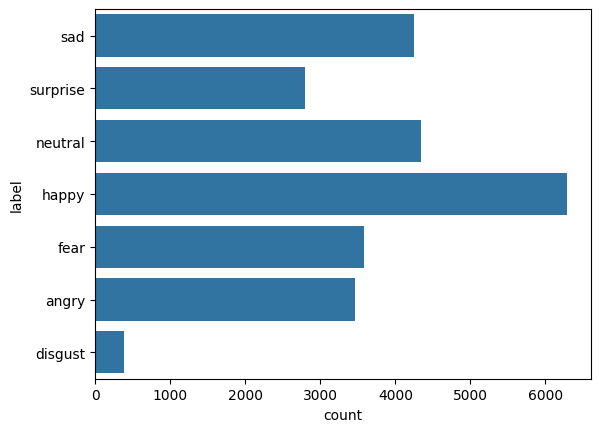

In [15]:
sns.countplot(train['label'])

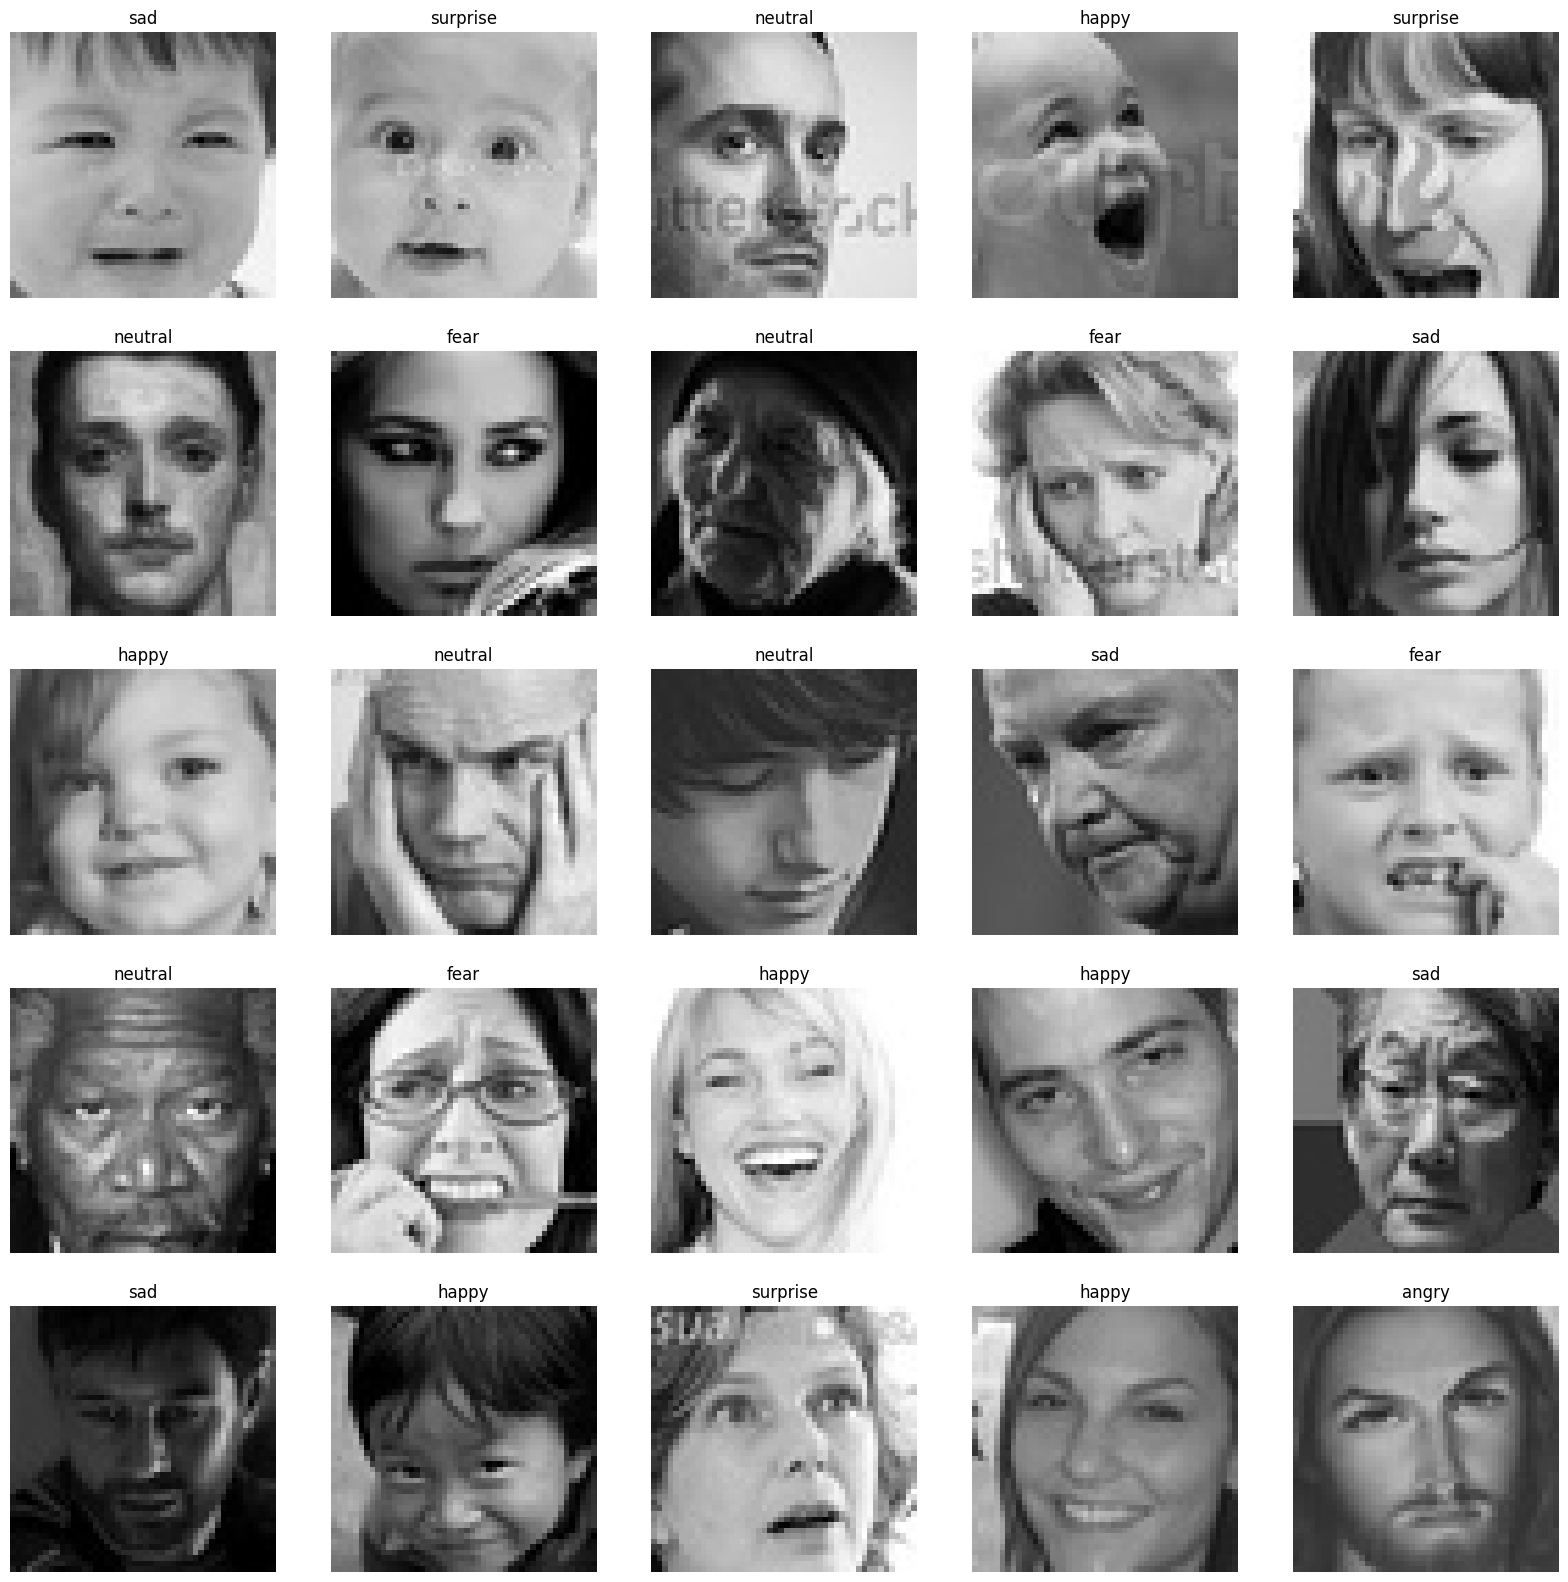

In [16]:
# display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, image_path, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(image_path)
    img = np.array(img)
    
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [17]:
def extract_features(images):
    features = []
    for image_path in tqdm(images):
        img = load_img(image_path, color_mode='grayscale')
        img = np.array(img)
        
        if DATASET == 'affectnet': # affectnet images are 96x96
            img = img[::2, ::2] # so downsampling to 48x48 is required
        
        features.append(img)
    
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    
    return features

In [18]:
train_features = extract_features(train['image'])
x_train = train_features / 255.0

  0%|          | 0/25117 [00:00<?, ?it/s]

In [19]:
test_features = extract_features(test['image'])
x_test = test_features / 255.0

  0%|          | 0/3589 [00:00<?, ?it/s]

In [20]:
valid_features = extract_features(valid['image'])
x_valid = valid_features / 255.0

  0%|          | 0/7181 [00:00<?, ?it/s]

In [21]:
labels = train['label'].unique()
print(labels)

['sad' 'surprise' 'neutral' 'happy' 'fear' 'angry' 'disgust']


In [22]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(labels)

y_train = le.transform(train['label'])
y_train = to_categorical(y_train, num_classes=len(labels))

y_test = le.transform(test['label'])
y_test = to_categorical(y_test, num_classes=len(labels))

y_valid = le.transform(valid['label'])
y_valid = to_categorical(y_valid, num_classes=len(labels))

In [23]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0.])

In [24]:
# config
input_shape = (48, 48, 1)
output_class = len(labels)

## Model Creation

In [85]:
# # 5 layer model
# model = Sequential(name='5-layer')

# # convolutional layers
# model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.25))

# model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# # fatten layer
# model.add(Flatten())

# # fully connected layers
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# # output layer
# model.add(Dense(output_class, activation='softmax'))

# _______________________________________________________

# 6 layer model
model = Sequential(name='6-layer')

# Convolutional layers
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(2048, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))

# global average pooling layer
model.add(GlobalAveragePooling2D())

# fully connected layers
model.add(Dense(output_class, activation='softmax'))

In [86]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "6-layer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_126 (Conv2D)                  │ (None, 48, 48, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_124              │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_124 (MaxPooling2D)     │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_124 (Dropout)                │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_127 (Conv2D)                  │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_125              │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_125 (MaxPooling2D)     │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_125 (Dropout)                │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_128 (Conv2D)                  │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_126              │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_126 (MaxPooling2D)     │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_126 (Dropout)                │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_129 (Conv2D)                  │ (None, 6, 6, 1024)          │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_127              │ (None, 6, 6, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_127 (MaxPooling2D)     │ (None, 3, 3, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_127 (Dropout)                │ (None, 3, 3, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_130 (Conv2D)                  │ (None, 3, 3, 1024)          │       9,438,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_128              │ (None, 3, 3, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_128 (MaxPooling2D)     │ (None, 2, 2, 1024)          │              

 Total params: 34,545,159 (131.78 MB)

 Trainable params: 34,535,175 (131.74 MB)

 Non-trainable params: 9,984 (39.00 KB)

In [87]:
# train the model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=100,
    validation_data=(x_valid, y_valid)
)

Epoch 1/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 493s 624ms/step - accuracy: 0.2447 - loss: 3.0865 - val_accuracy: 0.3321 - val_loss: 2.7106
Epoch 2/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 486s 620ms/step - accuracy: 0.3903 - loss: 2.2019 - val_accuracy: 0.3720 - val_loss: 2.2189
Epoch 3/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 485s 617ms/step - accuracy: 0.4382 - loss: 2.0487 - val_accuracy: 0.4146 - val_loss: 1.5064
Epoch 4/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 485s 617ms/step - accuracy: 0.4320 - loss: 2.0010 - val_accuracy: 0.4374 - val_loss: 1.8931
Epoch 5/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 487s 621ms/step - accuracy: 0.4827 - loss: 1.7501 - val_accuracy: 0.4852 - val_loss: 1.3786
Epoch 6/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 483s 615ms/step - accuracy: 0.5179 - loss: 1.6792 - val_accuracy: 0.4229 - val_loss: 2.2833
Epoch 7/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 483s 616ms/step - accuracy: 0.5417 - loss: 1.6119 - val_accuracy: 0.4172 - val_loss: 1.6583
Epoch 8/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 484s 616ms/step - accuracy: 

In [88]:
# save the model
model.save(f'models/{DATASET}_6layer.keras')

## Plot the Results

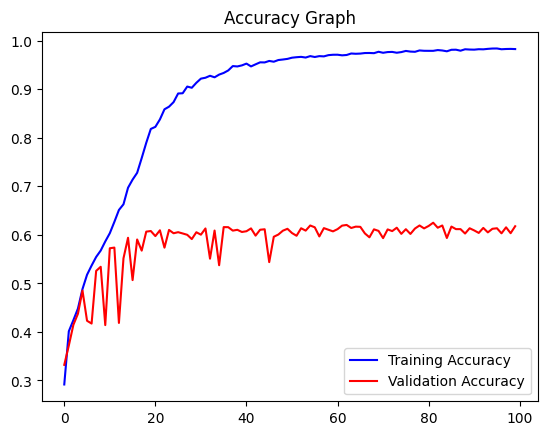

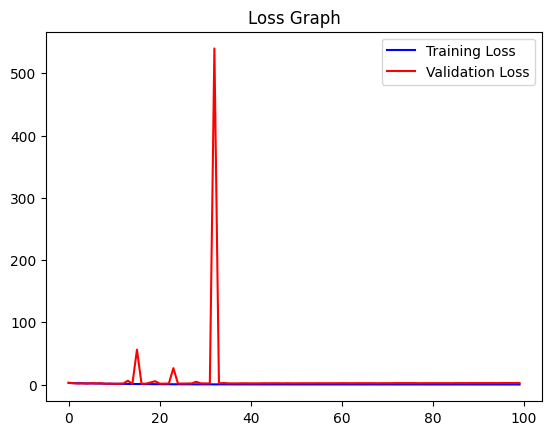

In [89]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Accuracy, F1, Precision, Recall

In [90]:
from sklearn.metrics import classification_report

# Przewidywanie klas na zestawie testowym
y_pred_prob = model.predict(x_test)
y_pred = np.array([np.eye(len(row))[np.argmax(row)] for row in y_pred_prob])

# Obliczenie miar
report = classification_report(y_test, y_pred, target_names=labels)

print(report)

113/113 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step
              precision    recall  f1-score   support

         sad       0.55      0.48      0.52       495
    surprise       0.64      0.51      0.57        55
     neutral       0.50      0.46      0.48       512
       happy       0.78      0.84      0.81       899
        fear       0.53      0.60      0.57       620
       angry       0.51      0.50      0.50       608
     disgust       0.78      0.73      0.76       400

   micro avg       0.62      0.62      0.62      3589
   macro avg       0.61      0.59      0.60      3589
weighted avg       0.62      0.62      0.62      3589
 samples avg       0.62      0.62      0.62      3589



## Test with Image Data

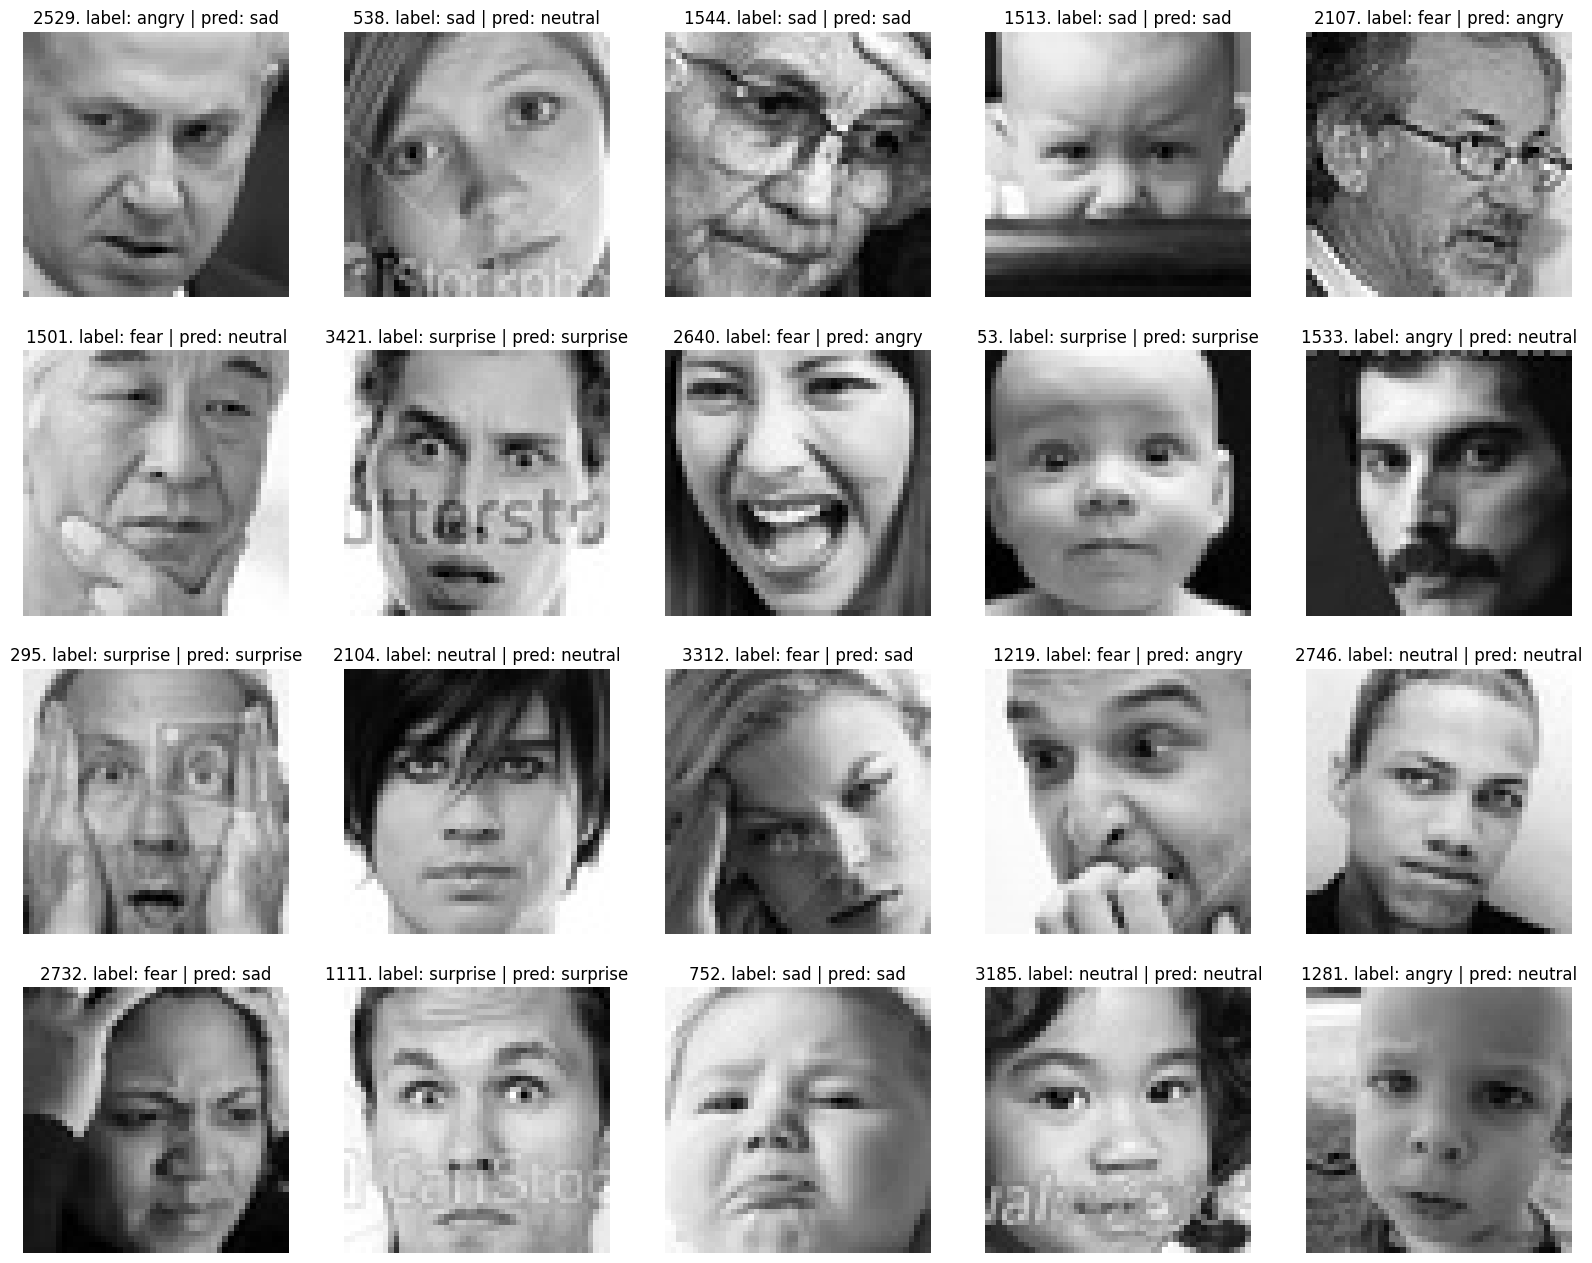

In [91]:
plt.figure(figsize=(20,20))

for i in range(20):
    plt.subplot(5, 5, i+1)

    img_index = random.randint(0, len(test))
    img = x_test[img_index]
    
    label = test['label'][img_index]

    pred = model.predict(img.reshape(1, 48, 48, 1), verbose=0)
    pred_label = le.inverse_transform([pred.argmax()])[0]
    
    plt.title(f"{img_index}. label: {label} | pred: {pred_label}")
    plt.imshow(img.reshape(48, 48), cmap='gray')
    plt.axis('off')